In [2]:
# user defined functions

import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
from scipy.signal import butter, filtfilt
from pykalman import KalmanFilter
import pingouin as pg
from scipy import fft

import multiprocessing as mp


#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [3]:
def fft_of_data(data,dt):
    data = data-np.mean(data)
    N = data.shape[0] # Length of data.
    try:
        yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])
    except ZeroDivisionError:
        yf= 0

    xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.

    return(xf, yf) # xf = frequency array. yf = amplitude or power.


In [4]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [5]:
df1 = pd.read_hdf(dir+'Windy/WindyMASigned.h5')
df2 = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
df3 = pd.read_hdf(dir+'Forest/ForestMASigned.h5')


In [6]:
# df=pd.concat([df1,df2,df3])
# df.reset_index(inplace=True, drop=True)

In [18]:
dat=df2
x=dat.xsrc
y=dat.ysrc
xdot = dat.gps_linear_x
ydot = dat.gps_linear_y

def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

r = np.sqrt(x**2 + y**2)
theta = wrapped_angular_diff(y,x)

rdot=(xdot * np.cos(theta) + ydot * np.sin(theta))
thetadot = (ydot * np.cos(theta) - xdot * np.sin(theta)) / r

result = pd.DataFrame({'r': r, 'theta': theta, 'r_dot': rdot, 'theta_dot': thetadot})


In [19]:
# def wrapped_angular_diff(a, b):
#     return np.arctan2(np.sin(a-b), np.cos(a-b))

# def compute_r_dot_theta_dot(args):
#     x, y, gps_linear_x, gps_linear_y = args
#     # Convert from Cartesian to Polar
#     r = math.sqrt(x**2 + y**2)
#     theta = np.arctan2(y,x)
    
#     # Calculate r_dot and theta_dot
#     r_dot = gps_linear_x * math.cos(theta) + gps_linear_y * math.sin(theta)
#     theta_dot = (gps_linear_y * math.cos(theta) - gps_linear_x * math.sin(theta)) / r

#     return r, theta, r_dot, theta_dot

# # Prepare the data for the compute_r_dot_theta_dot function
# data = list(zip(df1['xsrc'], df1['ysrc'], df1['gps_linear_x'], df1['gps_linear_y']))

# # Create a multiprocessing Pool and map the function to the data
# with mp.Pool(mp.cpu_count()) as pool:
#     results = pool.map(compute_r_dot_theta_dot, data)

# # Convert the results to a DataFrame
# result = pd.DataFrame(results, columns=['r', 'theta', 'r_dot', 'theta_dot'])

# result['time'] = df1.time


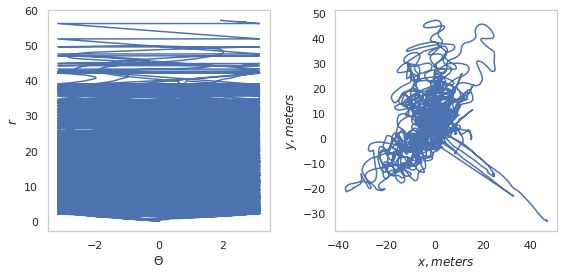

In [20]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))

ax1.plot(theta,r)
ax1.set_xlabel('$\Theta$')
ax1.set_ylabel('$r$')

ax1.grid(False)

ax2.plot(x,y)
ax2.set_xlabel('$x, meters$')
ax2.set_ylabel('$y, meters$')
# f.suptitle('Length of Traj =  2500 s')
ax2.grid(False)
f.tight_layout()
# f.savefig('../../Figure/lws1.jpeg', dpi=300, bbox_inches = "tight")

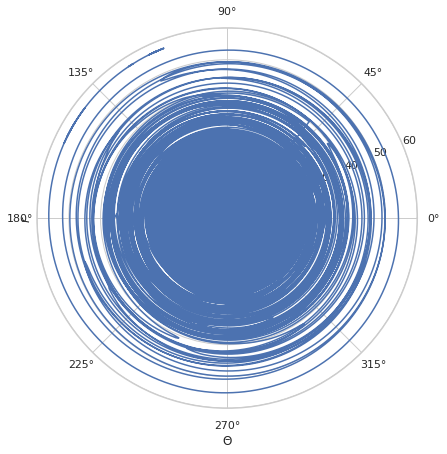

In [26]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection='polar')
ax.plot(result.theta, result.r)
ax.set_xlabel('$\Theta$')
ax.set_ylabel('$r$')

fig.savefig('../../Figure/lws2.jpeg', dpi=300, bbox_inches = "tight")

In [22]:
dt=df1.master_time[1]-df1.master_time[0]
f1, rdot_fft = fft_of_data(np.array(rdot),dt)
f2, thetadot_fft= fft_of_data(np.array(thetadot),dt)

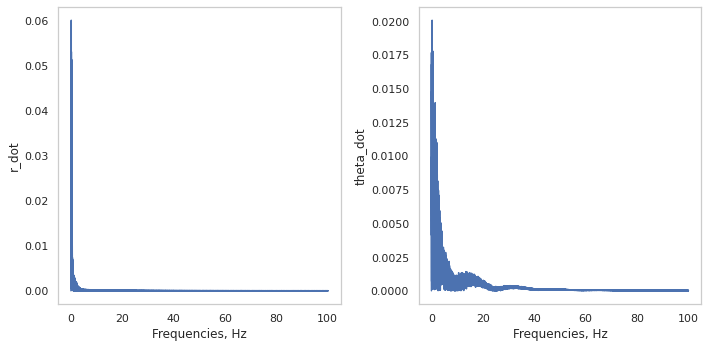

In [25]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(f1,rdot_fft)
# ax1.set_xlim(0,10)
ax1.set_xlabel('Frequencies, Hz')
ax1.set_ylabel('r_dot')
ax1.grid(False)

ax2.plot(f2,thetadot_fft)
# ax2.set_xlim(0,10)
ax2.set_xlabel('Frequencies, Hz')
ax2.set_ylabel('theta_dot')
ax2.grid(False)
# f.suptitle('Length of Traj =  2500 s')

f.tight_layout()
f.savefig('../../Figure/lws3.jpeg', dpi=300, bbox_inches = "tight")

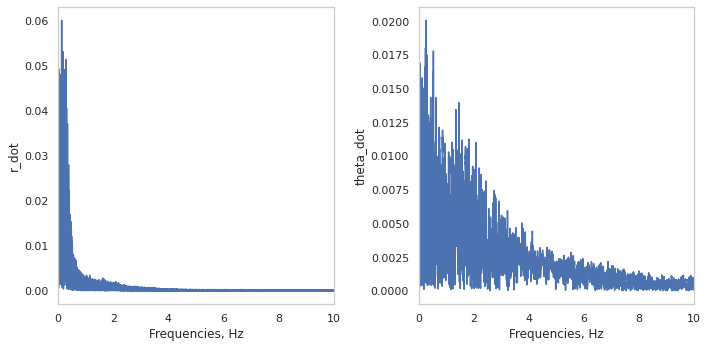

In [27]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(f1,rdot_fft)
ax1.set_xlim(0,10)
ax1.set_xlabel('Frequencies, Hz')
ax1.set_ylabel('r_dot')
ax1.grid(False)

ax2.plot(f2,thetadot_fft)
ax2.set_xlim(0,10)
ax2.set_xlabel('Frequencies, Hz')
ax2.set_ylabel('theta_dot')
ax2.grid(False)
# f.suptitle('Length of Traj =  2500 s')

f.tight_layout()
f.savefig('../../Figure/lws4.jpeg', dpi=300, bbox_inches = "tight")

/tmp/ipykernel_16829/1162143049.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(f1), np.log10(rdot_fft), label='r_dot')
/tmp/ipykernel_16829/1162143049.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(f2), np.log10(thetadot_fft), label='theta_dot', alpha=0.6)


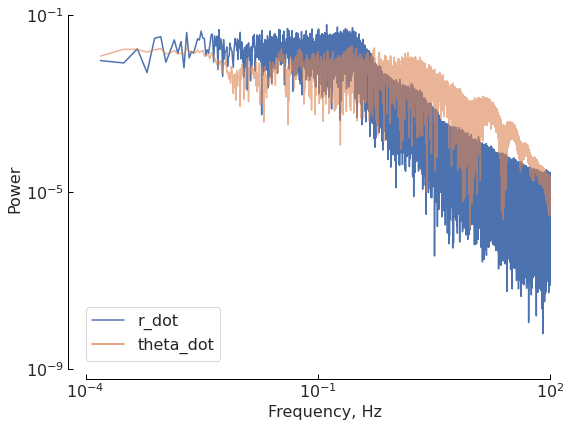

In [28]:
f,ax = plt.subplots(1,1, figsize=(8,6))

# ax.axvspan(-3.5, -1,  alpha=0.2)
# ax.axvline(1, color='r')
ax.plot(np.log10(f1), np.log10(rdot_fft), label='r_dot')
ax.plot(np.log10(f2), np.log10(thetadot_fft), label='theta_dot', alpha=0.6)

ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Power')
ax.grid(False)



mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
                            smart_bounds=True, xticks=[-4,-1,2],yticks=[-9,-5,-1],linewidth=1)
ax.set_xticklabels([r'$10^{-4}$',r'$10^{-1}$', r'$10^{2}$'])
ax.set_yticklabels([r'$10^{-9}$',r'$10^{-5}$', r'$10^{-1}$'])

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)

# f.suptitle('Trajectory Length = 25 s')

leg = ax.legend(loc='lower left', fontsize=16)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

f.savefig('../../Figure/lws5.jpeg', dpi=300, bbox_inches = "tight")

In [328]:
r_dot_fft = np.fft.fft(result['r_dot'])
theta_dot_fft = np.fft.fft(result['theta_dot'])
dt=result.time[1]-result.time[0]
frequencies = np.fft.fftfreq(len(result['r_dot']), d=dt)[:len(result['r_dot'])//2]
r_dot_fft = r_dot_fft[:len(result['r_dot'])//2]
theta_dot_fft = theta_dot_fft[:len(result['theta_dot'])//2]

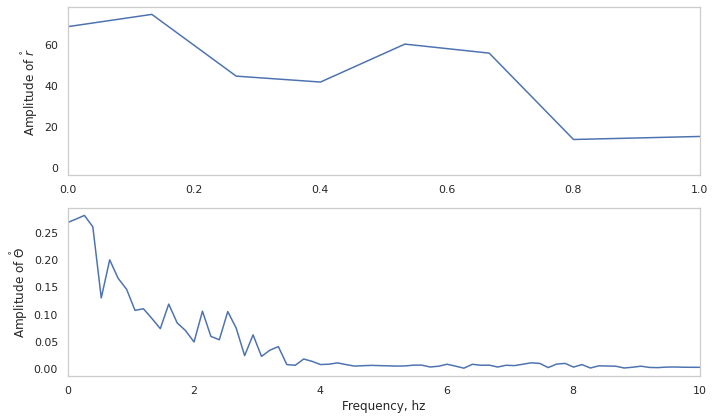

In [329]:

f, ax = plt.subplots(2,1, figsize=(10, 6))

ax[0].grid(False)
ax[0].plot(frequencies, np.abs(r_dot_fft))

ax[0].set_ylabel('Amplitude of $\overset{\circ}{r}$')
# ax[0].set_title('Frequency spectrum of r_dot')
ax[0].set_xlim(0,1)

ax[1].grid(False)
ax[1].plot(frequencies, np.abs(theta_dot_fft))

ax[1].set_xlabel('Frequency, hz')
ax[1].set_ylabel('Amplitude of $\overset{\circ}{\Theta}$')
# ax[1].set_title('Frequency spectrum of theta_dot')
ax[1].set_xlim(0,10)

# f.suptitle('with wrapped_method')
f.tight_layout()
# f.savefig('../../Figure/snippet3.jpeg', dpi=300, bbox_inches = "tight")

/tmp/ipykernel_520608/351222781.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(frequencies), np.log10(np.abs(r_dot_fft)) , label='$\overset{\circ}{r}$')
/tmp/ipykernel_520608/351222781.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(frequencies), np.log10(np.abs(theta_dot_fft)), label='$\overset{\circ}{\Theta}$')


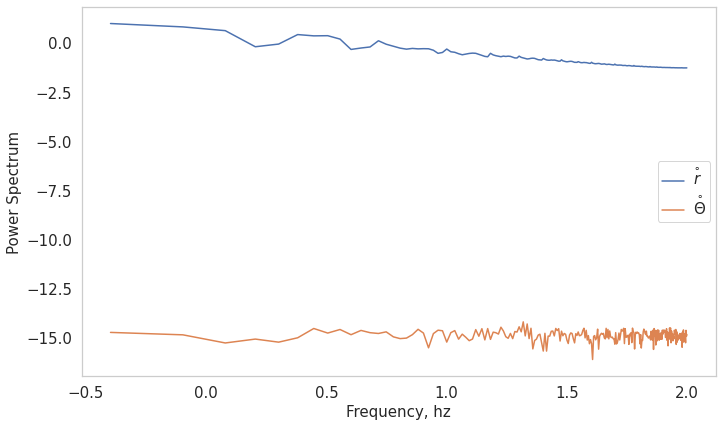

In [293]:
f, ax = plt.subplots(1,1, figsize=(10, 6))

ax.grid(False)
ax.plot(np.log10(frequencies), np.log10(np.abs(r_dot_fft)) , label='$\overset{\circ}{r}$')
ax.plot(np.log10(frequencies), np.log10(np.abs(theta_dot_fft)), label='$\overset{\circ}{\Theta}$')

ax.set_xlabel('Frequency, hz')
ax.set_ylabel('Power Spectrum')

# mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
#                             smart_bounds=True, xticks=[-3,-1,2],yticks=[-15,-10,0,5],linewidth=1)

# ax.set_xticklabels([r'$10^{-3}$',r'$10^{-1}$', r'$10^{2}$'])
# ax.set_yticklabels([r'$10^{-15}$',r'$10^{-10}$',r'$10^{0}$', r'$10^{5}$'])

ax.legend()

f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/snippet4.jpeg', dpi=300, bbox_inches = "tight")

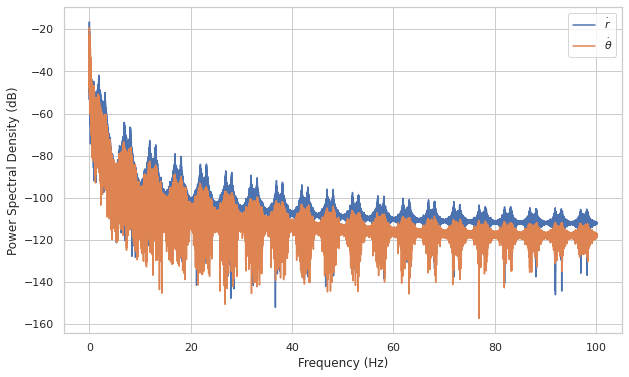

In [109]:
# Compute FFT
r_dot_fft = np.fft.fft(result['r_dot'])
theta_dot_fft = np.fft.fft(result['theta_dot'])

# Compute power spectral density (squared absolute value of FFT)
psd_r_dot = np.abs(r_dot_fft)**2
psd_theta_dot = np.abs(theta_dot_fft)**2

# Normalize the power spectral densities
psd_r_dot /= np.sum(psd_r_dot)
psd_theta_dot /= np.sum(psd_theta_dot)

# Get the frequencies
dt = result.time[1] - result.time[0]
frequencies = np.fft.fftfreq(len(result['r_dot']), d=dt)

# Select only the positive frequencies
frequencies = frequencies[:len(frequencies)//2]
psd_r_dot = psd_r_dot[:len(psd_r_dot)//2]
psd_theta_dot = psd_theta_dot[:len(psd_theta_dot)//2]


r_dot_fft = r_dot_fft[:len(r_dot_fft)//2]
theta_dot_fft = theta_dot_fft[:len(theta_dot_fft)//2]

# Plot on log scale
plt.figure(figsize=(10, 6))
plt.plot(frequencies, 10 * np.log10(psd_r_dot), label='$\dot{r}$')
plt.plot(frequencies, 10 * np.log10(psd_theta_dot), label='$\dot{\\theta}$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.legend()
plt.grid(False)

plt.savefig('../../Figure/power_spec_normalized.jpeg', dpi=300, bbox_inches = "tight")
plt.show()

### Distribution of where we walked relative to the source

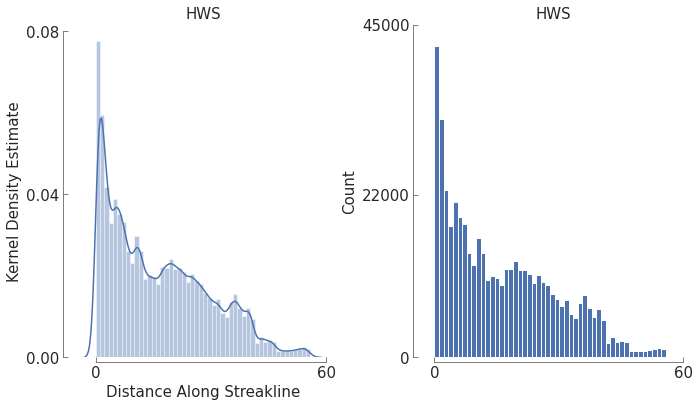

In [71]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(df1.distance_from_source_a*df1.xsign, bins=50, kde=True, norm_hist=True, ax=ax1)
ax1.set_xlabel('Distance Along Streakline')
ax1.set_ylabel('Kernel Density Estimate')
ax1.grid(False)

ax1.set_title('HWS')
mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,0.04,0.08],
                            linewidth=0.5)

ax2.hist(df1.distance_from_source_a*df1.xsign, bins=50)
ax2.grid(False)
ax2.set_title('HWS')
ax2.set_ylabel('Count')
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,22000,45000],
                            linewidth=0.5)
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/hist_1.jpeg', dpi=300, bbox_inches = "tight")

In [ ]:
# # Initialize two empty lists for r_dot and theta_dot
# r_list = []
# theta_list = []
# r_dot_list = []
# theta_dot_list = []

# # Loop over each row in the DataFrame
# for i in range(len(df1)):
#     # Call the function and store the results
#     r, theta, r_dot, theta_dot = compute_r_dot_theta_dot(df1.iloc[i]['xsrc'], 
#                                                          df1.iloc[i]['ysrc'], df1.iloc[i]['gps_linear_x'], 
#                                                          df1.iloc[i]['gps_linear_y'])

#     # Append the results to the lists
#     r_list.append(r)
#     theta_list.append(theta)
#     r_dot_list.append(r_dot)
#     theta_dot_list.append(theta_dot)

# # Create a new DataFrame with the results
# result = pd.DataFrame({
#     'r' : r_list,
#     'theta' : theta_list,
#     'r_dot': r_dot_list,
#     'theta_dot': theta_dot_list,
# })

# result['time']=df1.time